In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

C:\Users\oicmy\AppData\Local\Temp\ipykernel_73188\1341870611.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = '215d3c1ea7d0c562774a8c6e4b157ac0.xlsx'
data = pd.ExcelFile(file_path)

In [3]:
data.sheet_names

['2022']

In [4]:
df = data.parse('2022')

In [5]:
columns_to_extract = [
    "Odczyn pH - wartość terenowa",
    "Temperatura - wartość terenowa [°C]",
]

start_column = "Ogólny węgiel organiczny [mgC/l]"
end_column = df.columns[-2]

columns_for_mineralization = df.loc[:, start_column:end_column]

columns_for_mineralization = columns_for_mineralization.replace({',': '.'}, regex=True)
columns_for_mineralization = columns_for_mineralization.replace({r'[<>]': ''}, regex=True)
columns_for_mineralization = columns_for_mineralization.apply(pd.to_numeric, errors='coerce')

In [6]:
columns_for_mineralization.head()

,Ogólny węgiel organiczny [mgC/l],Amonowy jon [mgNH4/l],Antymon [mgSb/l],Arsen [mgAs/l],Azotany [mgNO3/l],Azotyny [mgNO2/l],Bar [mgBa/l],Beryl [mgBe/l],Bor [mgB/l],Chlorki [mgCl/l],...,Siarczany [mgSO4/l],Sód [mgNa/l],Srebro [mgAg/l],Tal [mgTl/l],Tytan [mgTi/l],Uran [mgU/l],Wanad [mgV/l],Wapń [mgCa/l],Wodorowęglany [mgHCO3/l],Żelazo [mgFe/l]
0,14.0,1.04,0.00005,0.002,0.65,0.66,0.109,0.00005,0.10,332.0,...,34.60,204.7,0.00005,0.00005,0.003,0.00005,0.003,98.8,357.0,0.77
1,2.0,0.50,0.00005,0.002,0.19,0.04,0.073,0.00005,0.06,51.2,...,84.20,21.8,0.00005,0.00005,0.002,0.00005,0.001,99.5,244.0,1.85
2,2.0,1.13,0.00005,0.002,0.72,1.42,0.021,0.00005,1.00,800.0,...,6.95,622.7,0.00005,0.00005,0.002,0.00005,0.005,20.0,379.0,0.11
3,1.9,5.58,0.00005,0.002,0.05,0.06,0.276,0.00005,0.26,448.0,...,61.60,292.3,0.00005,0.00005,0.002,0.00005,0.002,105.5,467.0,1.54
4,15.0,3.51,0.00005,0.002,0.11,0.01,0.023,0.00005,0.10,19.5,...,7.47,15.1,0.00005,0.00005,0.002,0.00005,0.001,89.5,360.0,0.02


In [64]:
df_selected = df[columns_to_extract]

df_selected = df_selected.replace({',': '.'}, regex=True)
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

df_selected.columns = [
    "ph_field",
    "temp_field",
]

In [65]:
file_path = 'cities_locations.xlsx'
cities_coordinates = pd.ExcelFile(file_path)

In [66]:
cities_coordinates.sheet_names

['Sheet1']

In [67]:
cities_coordinates_df = cities_coordinates.parse('Sheet1')

In [68]:
cities_coordinates_df.head()

,City,Region,Latitude,Longitude
0,Świnoujście,Świnoujście,53.904445,14.266023
1,Świnoujście,Świnoujście,53.904445,14.266023
2,Świnoujście,Świnoujście,53.904445,14.266023
3,Świnoujście,Świnoujście,53.904445,14.266023
4,Świnoujście,Świnoujście,53.904445,14.266023


In [69]:
df_selected_2 = pd.concat([df_selected, cities_coordinates_df], axis=1)

In [70]:
df_selected.head()

,ph_field,temp_field
0,7.14,11.7
1,7.19,11.5
2,7.76,11.7
3,7.51,12.1
4,7.15,10.0


In [71]:
df_selected["mineralization"] = columns_for_mineralization.sum(axis=1)

In [72]:
range_column = "Przedział ujętej warstwy wodonośnej [m p.p.t.]"
range_data = df[range_column].dropna()

def calculate_mean_range(range_str):
    try:
        min_val, max_val = map(float, range_str.replace(',', '.').split('-'))
        return (min_val + max_val) / 2
    except Exception:
        return None

df_selected["depth"] = range_data.apply(calculate_mean_range)

In [73]:
df_selected.head()

,ph_field,temp_field,mineralization,depth
0,7.14,11.7,1063.71434,14.0
1,7.19,11.5,522.47648,28.0
2,7.76,11.7,1850.88460,45.0
3,7.51,12.1,1436.56268,27.1
4,7.15,10.0,539.03194,28.0


In [74]:
def plot_histogram(dataFrame):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  for ax, column in zip(axes.flatten(), dataFrame.columns):
      counts, bins, patches = ax.hist(dataFrame[column].dropna(), bins=30, edgecolor='black', alpha=0.7)

      for count, bin_patch in zip(counts, patches):
          x_pos = bin_patch.get_x() + bin_patch.get_width() / 2  # Center text
          ax.text(x_pos, count, str(int(count) if count != 0 else ''), ha='center', va='bottom', fontsize=10)

      # ax.hist(df_selected[column].dropna(), bins=30, edgecolor='black', alpha=0.7, histtype='step')
      ax.set_title(f"Histogram of {column}")
      ax.set_xlabel(column)
      ax.set_ylabel("Frequency")
      ax.grid(True)

  plt.tight_layout()
  plt.show()

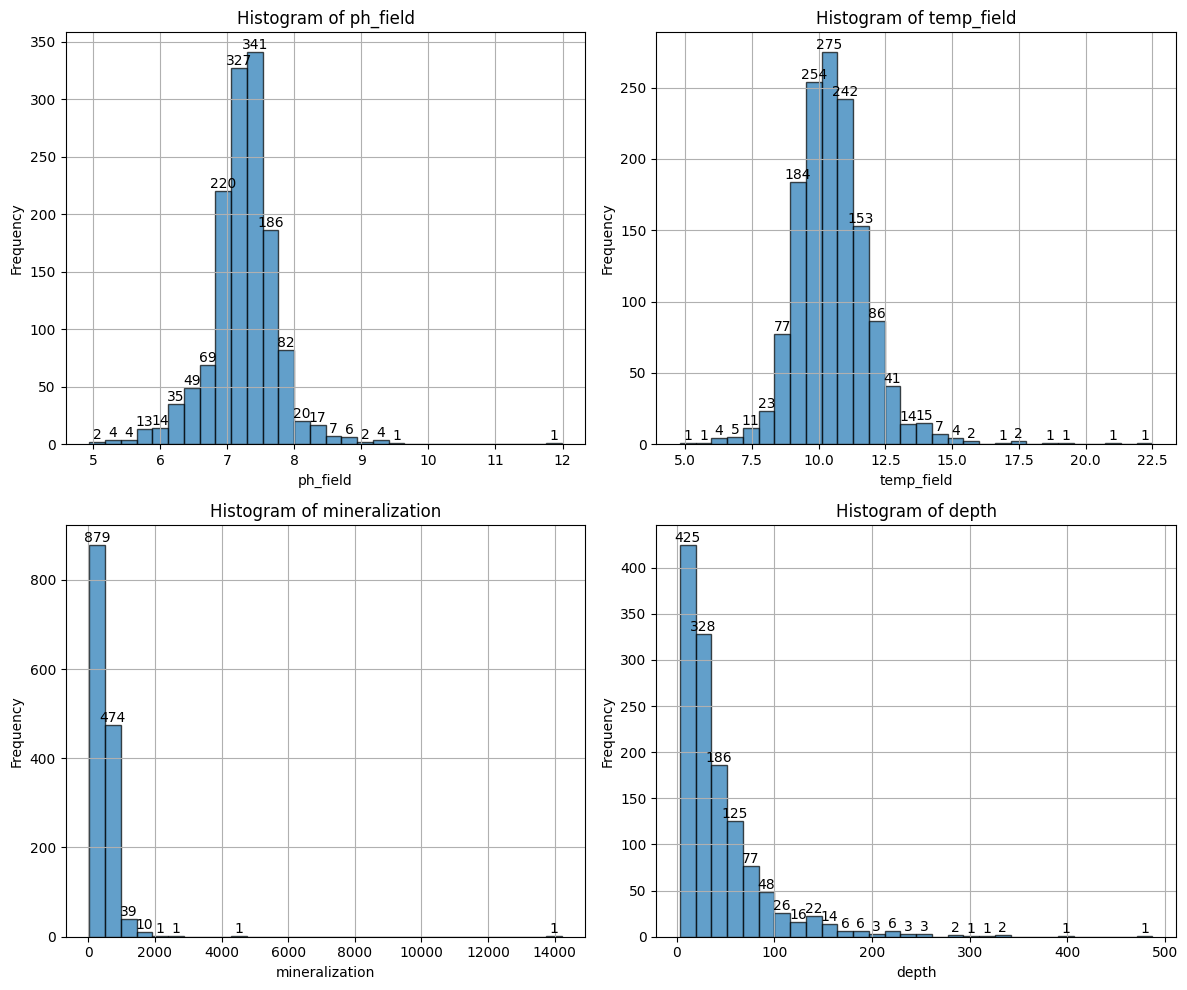

In [75]:
plot_histogram(df_selected)

In [76]:
thresholds = {'ph_field': 10, 'temp_field': 20.0, 'mineralization': 3000, 'depth': 375}

df_without_edge_values = df_selected.copy()

for column, threshold_value in thresholds.items():
    if column in df_without_edge_values.columns:
        df_without_edge_values = df_without_edge_values[df_without_edge_values[column] <= threshold_value]

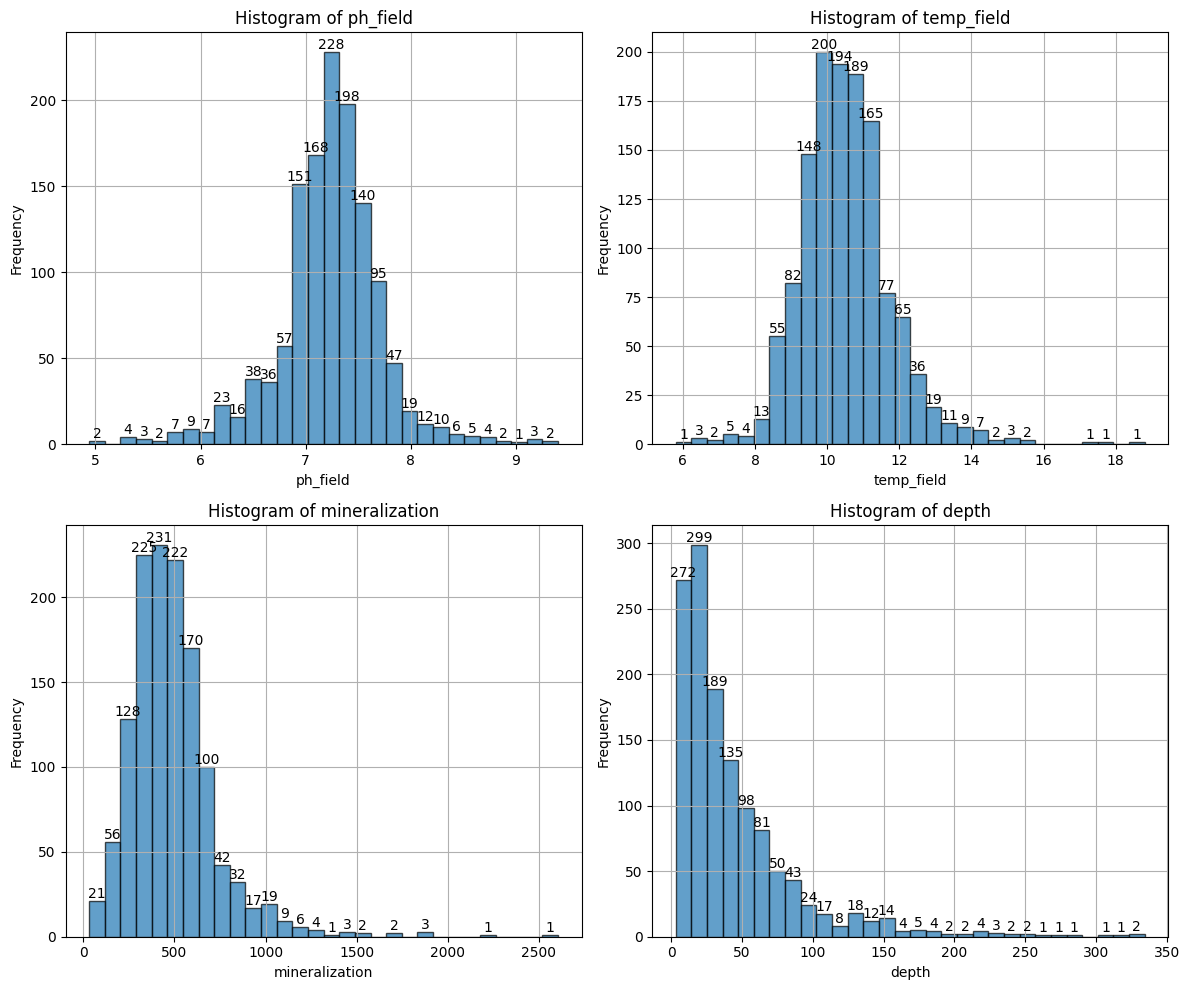

In [77]:
plot_histogram(df_without_edge_values)

pousuwac niektore skrajne wartosci, zeby poprawic skale
- im glebiej temperatura wieksza
- powyzej -> to wtedy mineralizacja wieksza
-

In [78]:
def find_outliers(data, k, r):
    n = len(data)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt(np.sum((data[i] - data[j]) ** 2))

    sorted_indices = np.argsort(dist_matrix, axis=1)
    k_closest_indices = sorted_indices[:, 1:k+1]
    max_distances = np.zeros(n)

    for i in range(n):
        max_distances[i] = max(dist_matrix[i, k_closest_indices[i]])

    sorted_max_distances = np.sort(max_distances)
    threshold_index = int((1 - r) * n)
    threshold = sorted_max_distances[threshold_index]

    outliers = np.where(max_distances > threshold)[0]

    return outliers, max_distances

In [ ]:
components = ['ph_field', 'temp_field', 'mineralization', 'depth']

def find_outlier_sets(dataframe, k, r):
  outlier_sets = []
  for component in components:
    outliers, max_distances = find_outliers(dataframe[component], k, r)
    # print(outliers)
    # print(len(outliers))
    outlier_sets.append(set(outliers))

  return outlier_sets

outlier_sets = find_outlier_sets(df_selected, k=10, r=0.5)

common_outliers = set.intersection(*outlier_sets)
print("Common Outliers:", common_outliers)
print("Number of Common Outliers:", len(common_outliers))

In [ ]:
outliers, max_distances = find_outliers(df_selected['ph_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[ 132  862  985  987 1029 1044 1132 1157 1275 1305 1345 1355]
12


In [ ]:
outliers, max_distances = find_outliers(df_selected['temp_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[ 165  643  658  819  821  849  938 1026 1161 1164 1175 1199 1241 1374]
14


In [ ]:
outliers, max_distances = find_outliers(df_selected['mineralization'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[   2   63   69  104  159  216  407  580  651  663 1017 1114 1199 1273]
14


In [ ]:
outliers, max_distances = find_outliers(df_selected['depth'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[]
0


In [80]:
def calculate_and_plot_outliers(dataframe, components, outlier_sets, k, r):
  for component, outliers in zip(components, outlier_sets):
      print(f'k = {k}, r = {r}, {len(outliers)}: {outliers}')

      y_values = np.zeros(len(dataframe[component]))
      plt.plot(dataframe[component], y_values, '|', label='Data', alpha=0.5)
      plt.plot(dataframe[component].iloc[list(outliers)], y_values[list(outliers)], '|', label='Outliers')
      plt.title(f"Plot of {component} with detected outliers")
      plt.xlabel("X Values")
      plt.ylabel("Y values")
      plt.legend()
      plt.show()

In [ ]:
calculate_and_plot_outliers(df_selected, components, outlier_sets, k=10, r=0.01)

standaryzacja/normalizacja

## Outliers after removing the most edge values

In [ ]:
df_without_edge_values = df_without_edge_values.reset_index(drop=True)
cleaned_outlier_sets = find_outlier_sets(df_without_edge_values, k=10, r=0.02)

k = 10, r = 0.02, 24: {130, 1291, 1050, 815, 951, 1208, 1082, 831, 964, 1222, 1101, 1230, 465, 982, 988, 95, 1250, 1002, 1262, 111, 241, 1268, 1013, 761}


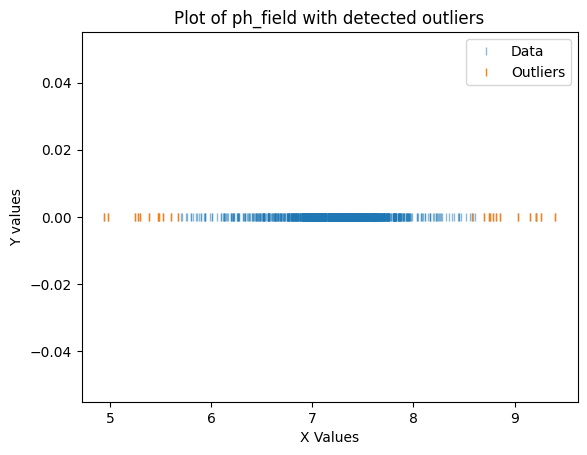

k = 10, r = 0.02, 25: {776, 1288, 906, 794, 283, 1051, 671, 800, 161, 1057, 419, 1066, 820, 698, 190, 191, 704, 838, 719, 986, 1114, 1002, 1006, 1008, 754}


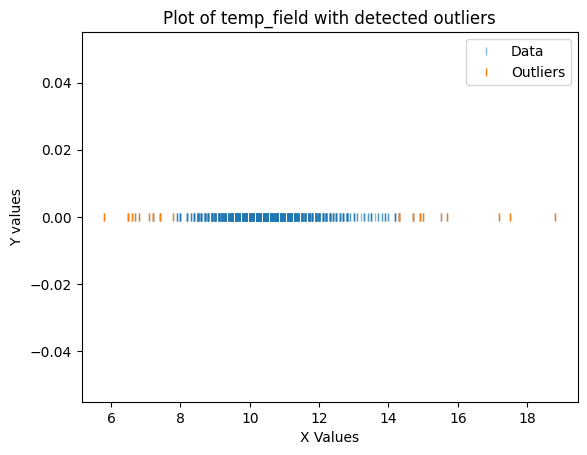

k = 10, r = 0.02, 25: {2, 3, 643, 394, 12, 396, 398, 1165, 155, 1055, 1063, 1065, 564, 1206, 1213, 68, 80, 210, 853, 215, 102, 1002, 107, 1143, 632}


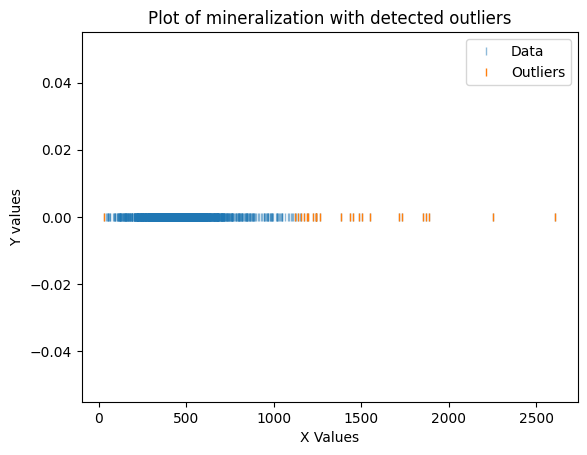

k = 10, r = 0.02, 25: {640, 130, 520, 648, 652, 271, 660, 1177, 923, 158, 820, 952, 837, 839, 846, 1104, 339, 1114, 95, 361, 109, 111, 112, 1009, 1279}


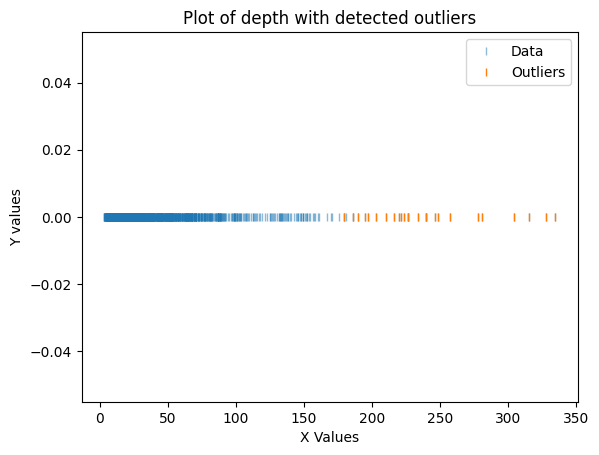

In [21]:
calculate_and_plot_outliers(df_without_edge_values, components, cleaned_outlier_sets, k=10, r=0.02)

## Standarization

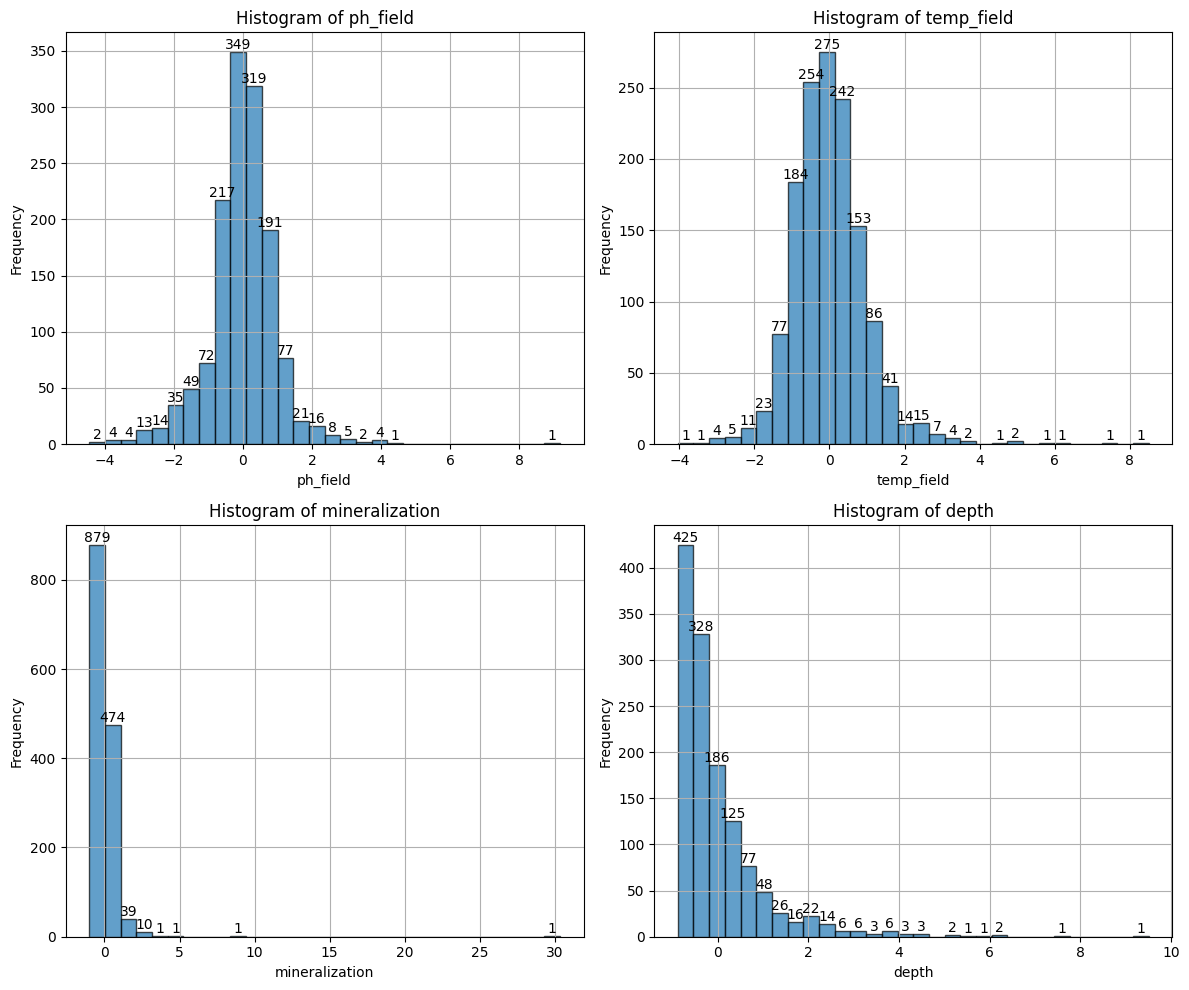

In [83]:
scaler = StandardScaler()

columns_to_scale = df_selected.columns
df_standardized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_standardized)

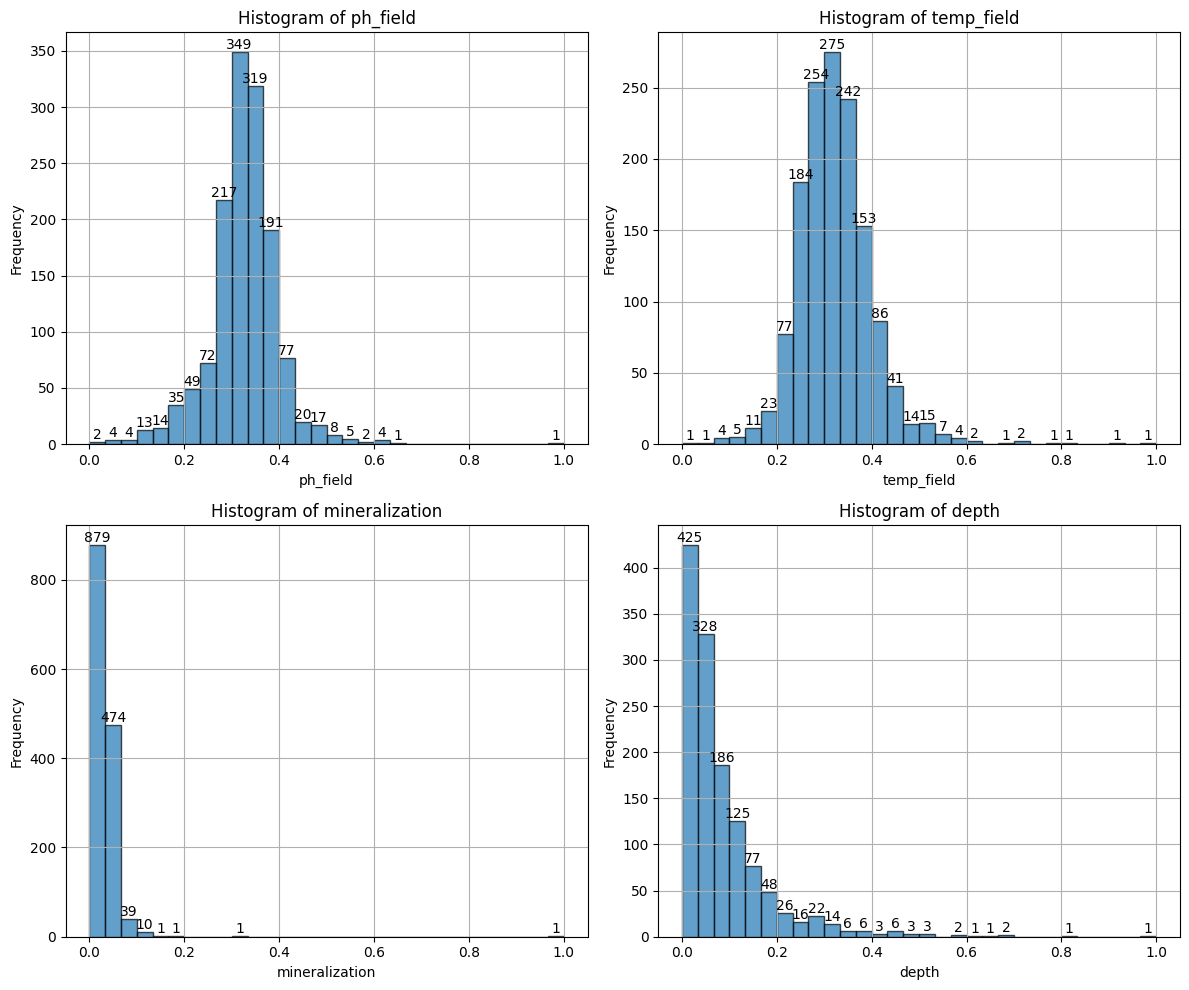

In [84]:
scaler = MinMaxScaler()

columns_to_scale = df_selected.columns
df_normalized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized)

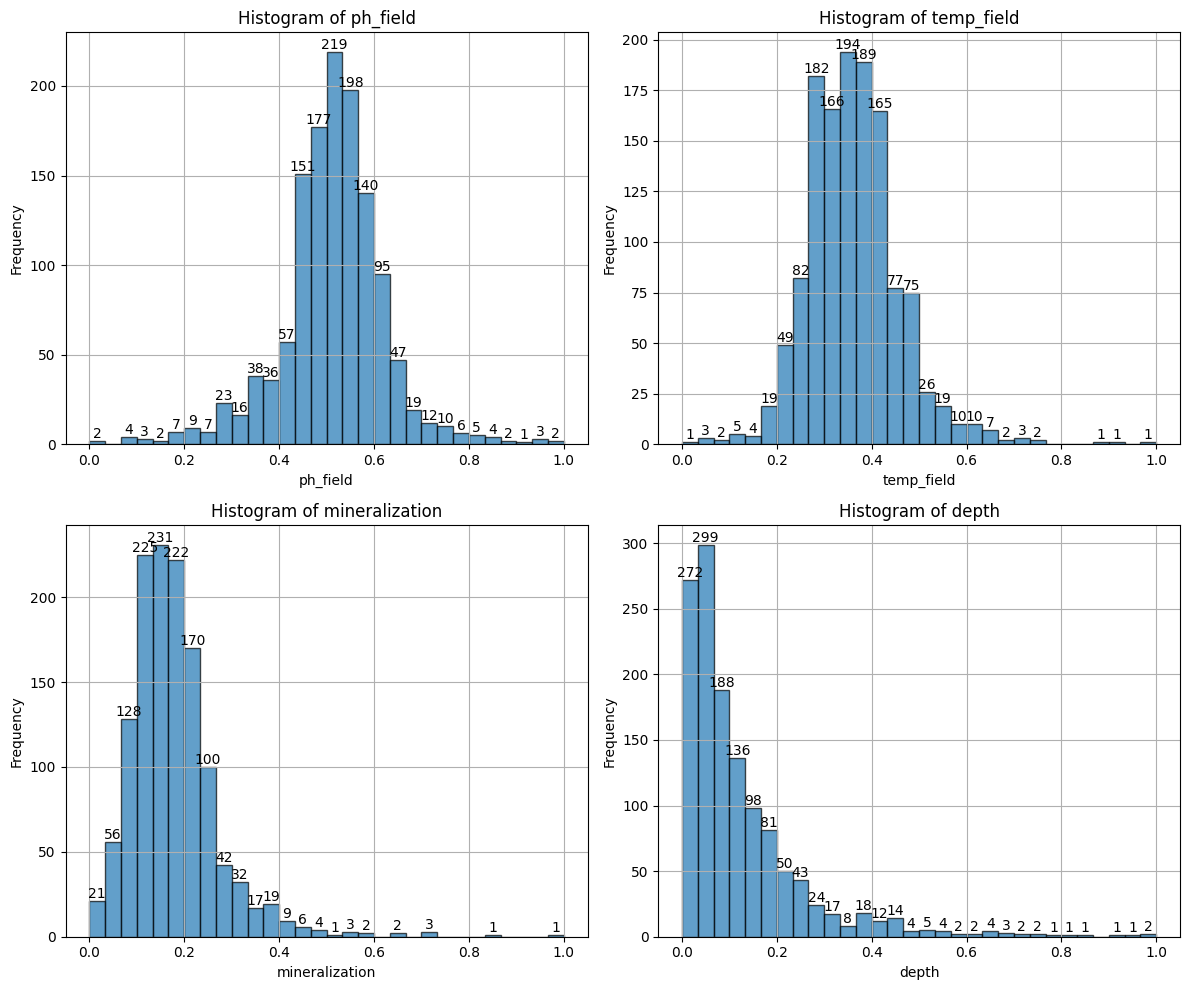

In [85]:
scaler = MinMaxScaler()

columns_to_scale = df_without_edge_values.columns
df_normalized_without_edge_values = pd.DataFrame(scaler.fit_transform(df_without_edge_values[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized_without_edge_values)

## Dependency plots

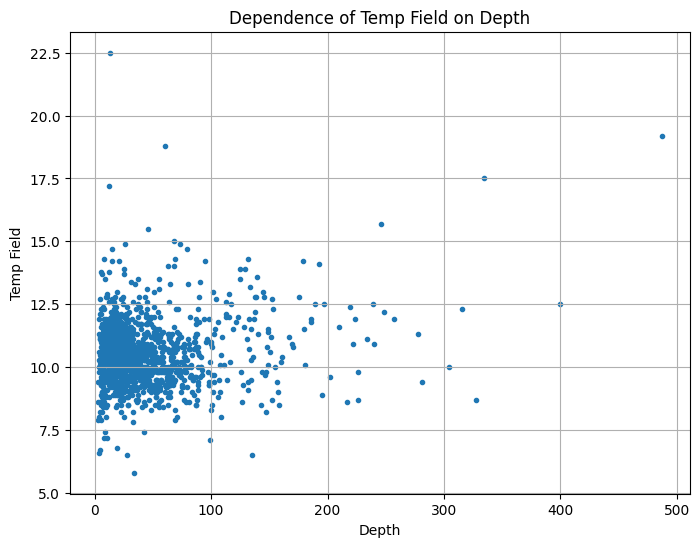

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

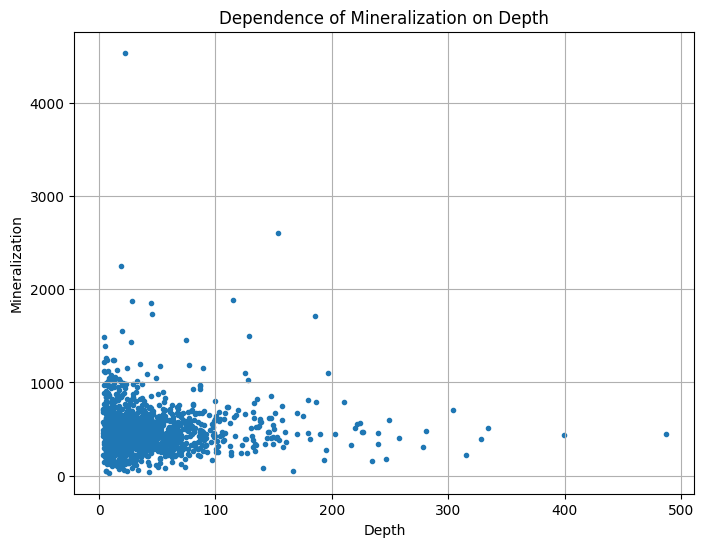

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['mineralization'], marker='.')
plt.title('Dependence of Mineralization on Depth')
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.grid(True)
plt.show()

## Dependencies for data without most edge cases

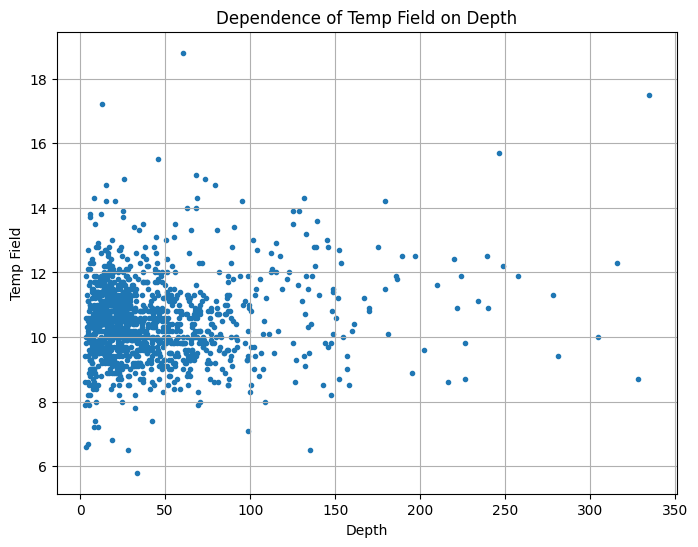

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

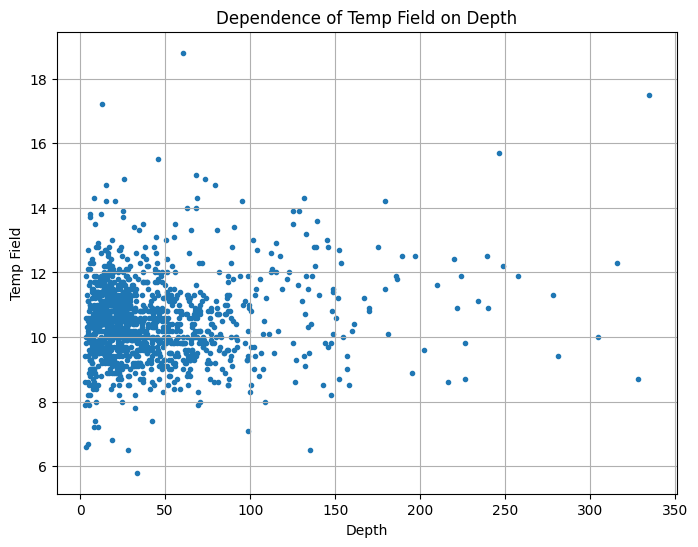

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

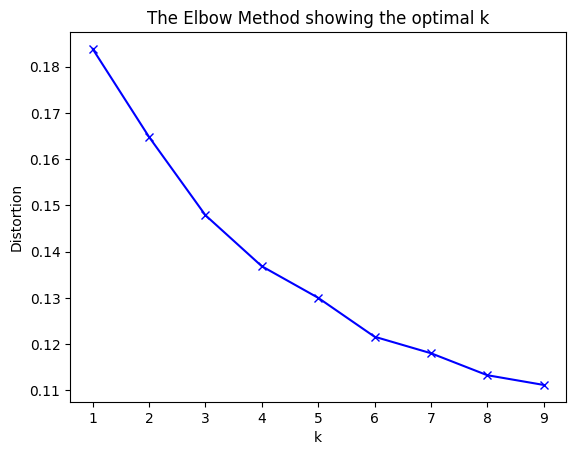

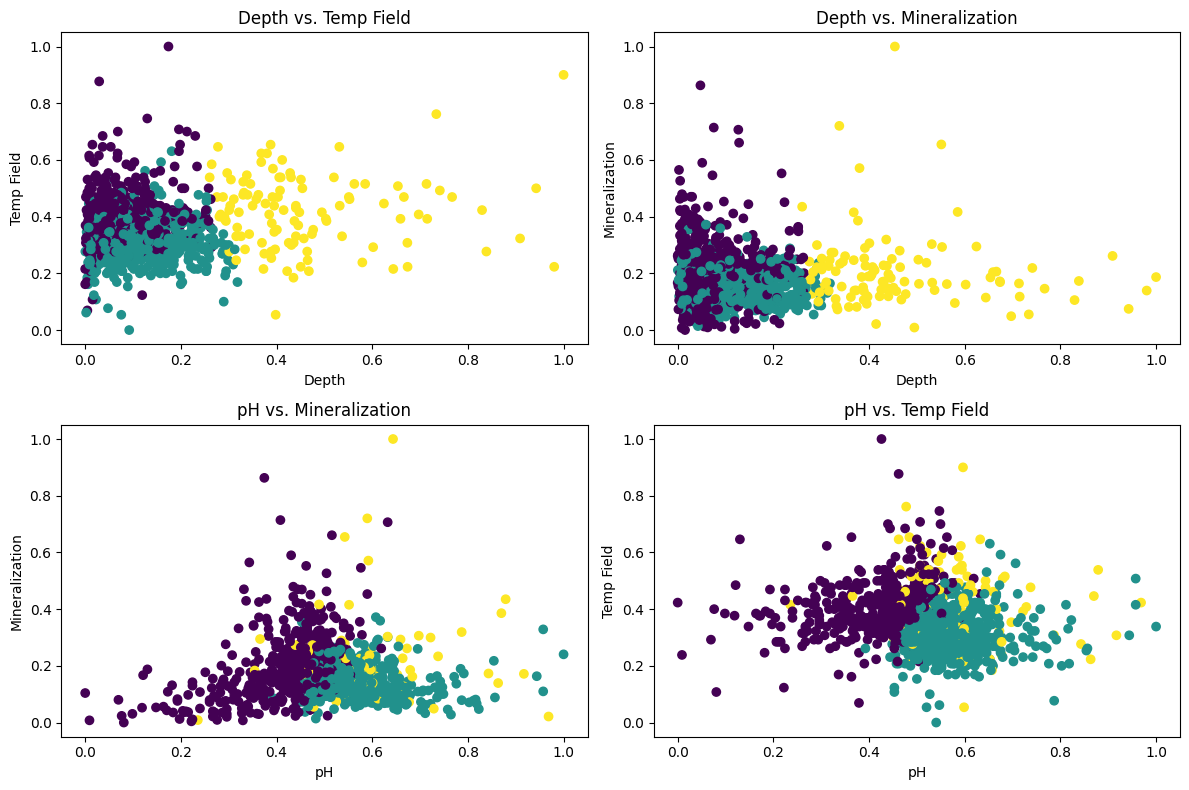

In [61]:
# prompt: use k-means method to do clusterization over these 4 parameters and show me that in 2D plots

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# Replace with your actual DataFrame if different

# Select the columns for clustering
X = df_normalized_without_edge_values[['ph_field', 'temp_field', 'mineralization', 'depth']]

# Determine the optimal number of clusters (e.g., using the elbow method)
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow method
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Choose the optimal k based on the elbow plot
optimal_k = 3  # Replace with your chosen k

# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
df_normalized_without_edge_values['cluster'] = kmeans.fit_predict(X)

# Create 2D scatter plots for different pairs of features
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.title('Depth vs. Temp Field')

plt.subplot(2, 2, 2)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.title('Depth vs. Mineralization')


plt.subplot(2, 2, 3)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Mineralization')
plt.title('pH vs. Mineralization')

plt.subplot(2, 2, 4)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Temp Field')
plt.title('pH vs. Temp Field')

plt.tight_layout()
plt.show()

- grupy minaralizacji (0, mala srednia, duza)
- bayes, drzewa decyzyjne
- przejrzec minerazlizacje (lub ktorys inny parametr), zeby moc ja przewidywac na podstawie pozostaych 3 parametrow

In [63]:
df_normalized_without_edge_values.head()

,ph_field,temp_field,mineralization,depth,cluster
0,0.493274,0.453846,0.400885,0.033183,0
1,0.504484,0.438462,0.190672,0.075415,0
2,0.632287,0.453846,0.706616,0.126697,0
3,0.576233,0.484615,0.545696,0.072700,0
4,0.495516,0.323077,0.197102,0.075415,1


In [1]:
import numpy as np

new_data = []
for i in range(20):
    # Randomly select a cluster from the existing data
    cluster = np.random.choice(df_normalized_without_edge_values['cluster'].unique())

    # Get data points from the selected cluster
    cluster_data = df_normalized_without_edge_values[df_normalized_without_edge_values['cluster'] == cluster]

    # Sample from the means and std of each column
    new_point = {}
    for col in ['ph_field', 'temp_field', 'mineralization', 'depth']:
      new_point[col] = np.random.normal(cluster_data[col].mean(), cluster_data[col].std())
    new_data.append(new_point)


new_df = pd.DataFrame(new_data)

# Predict the clusters for the new data points
new_df['cluster'] = kmeans.predict(new_df)

# Create the plots
plt.figure(figsize=(12, 8))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    if i == 1:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'], label='Original Data')
        plt.scatter(new_df['depth'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100, label='New Data')
        plt.xlabel('Depth')
        plt.ylabel('Temp Field')
        plt.title('Depth vs. Temp Field')
    elif i == 2:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['depth'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('Depth')
        plt.ylabel('Mineralization')
        plt.title('Depth vs. Mineralization')
    elif i == 3:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Mineralization')
        plt.title('pH vs. Mineralization')
    elif i == 4:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Temp Field')
        plt.title('pH vs. Temp Field')

    plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'df_normalized_without_edge_values' is not defined

In [62]:
new_df.head()

,ph_field,temp_field,mineralization,depth,cluster
0,0.449289,0.424662,0.065070,0.207650,0
1,0.264676,0.342320,0.304101,0.142615,0
2,0.513678,0.409655,0.187942,0.161843,0
3,0.646407,0.232339,0.218185,0.098096,1
4,0.452640,0.281362,0.353122,0.397371,2
